# Watson Visual Recognition Training with Spectrogram Images from SETI Signal Data

* https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/
* https://www.ibm.com/watson/developercloud/doc/visual-recognition/customizing.html
* https://github.com/watson-developer-cloud/python-sdk
* https://github.com/watson-developer-cloud/python-sdk/blob/master/watson_developer_cloud/visual_recognition_v3.py

<hr>

## Install the Watson Developer Cloud Python SDK

* Install the Python SDK if has not been previously installed **`!pip install --upgrade watson-developer-cloud`**
* Restart the kernel, after installing the SDK

In [ ]:
#!pip install --user --upgrade watson-developer-cloud

# WARNING: YOU MUST READ THIS.

ALL TEAMS WILL BE SHARING A WATSON API KEY FOR THIS WEEKEND. 

THIS MEANS IT IS POSSIBLE FOR YOU TO ACCIDENTALLY DELETE ANOTHER TEAM'S CLASSIFIER. THIS IS BAD. DO NOT DO THIS.

IF YOU NEED TO DELETE YOUR OWN CLASSIFIER IN ORDER TO START OVER, WHICH YOU MIGHT WANT TO DO, YOU CAN RUN THE CODE BELOW THAT DOES THIS, BUT DO NOT MODIFY THAT CODE. THAT CODE WILL CREATE AND DELETE YOUR TEAM'S CLASSIFIER.

In [12]:
#Making a local folder to put my data.

### SET YOUR TEAM NAME HERE! Use this folder to save intermediate results
teamname = "machine_contact_png"

mydatafolder = os.path.join( os.environ['PWD'], teamname )  
if os.path.exists(mydatafolder) is False:
    raise Exception('This folder needs to already exist. See the Build_And_Package_Spectrograms_HackathonSpark notebook')
    
    
zipfilefolder = mydatafolder + '/zipfiles'
if os.path.exists(zipfilefolder) is False:
    raise Exception('This folder needs to already exist. See the Build_And_Package_Spectrograms_HackathonSpark notebook')

In [13]:
from watson_developer_cloud import VisualRecognitionV3
apiVer = VisualRecognitionV3.latest_version #'2016-05-20'
classifier_prefix = teamname + "_v1_"

#You can sign up with WatsonVR through Bluemix to get a key
#However, Hackathon participants will be provided with a WATSON VR key that has more free API calls per day.
apiKey = 'c70486e04c0e6ac12314da71f2fdb88992420c33'  


In [ ]:
# @hidden_cell
apiKey = ''

In [15]:
!ls -lah $mydatafolder/zipfiles

total 4.3G
drwx------ 2 s18f-42b3305d048694-5fca760d00b1 users 8.0K Jun 10 15:35 .
drwx------ 5 s18f-42b3305d048694-5fca760d00b1 users 4.0K Jun 10 15:26 ..
-rw------- 1 s18f-42b3305d048694-5fca760d00b1 users  26M Jun 10 15:34 classification_10_narrowbanddrd.zip
-rw------- 1 s18f-42b3305d048694-5fca760d00b1 users  26M Jun 10 15:33 classification_10_narrowband.zip
-rw------- 1 s18f-42b3305d048694-5fca760d00b1 users  26M Jun 10 15:33 classification_10_noise.zip
-rw------- 1 s18f-42b3305d048694-5fca760d00b1 users  26M Jun 10 15:33 classification_10_squiggle.zip
-rw------- 1 s18f-42b3305d048694-5fca760d00b1 users  26M Jun 10 15:34 classification_11_narrowbanddrd.zip
-rw------- 1 s18f-42b3305d048694-5fca760d00b1 users  26M Jun 10 15:33 classification_11_narrowband.zip
-rw------- 1 s18f-42b3305d048694-5fca760d00b1 users  13M Jun 10 15:33 classification_11_noise.zip
-rw------- 1 s18f-42b3305d048694-5fca760d00b1 users  22M Jun 10 15:33 classification_11_squiggle.zip
-rw------- 1 s18f-42b3305d04

In [16]:
from __future__ import division

import cStringIO
import glob
import json
import os
import requests
import time
import timeit
import zipfile
import copy

from random import randint

import matplotlib.pyplot as plt
import numpy as np

import ibmseti



<br/>
## Init the Watson Visual Recognition Python Library

* you may need to install the SDK first: **`!pip install --upgrade watson-developer-cloud`**
* you will need the **API** key from the Watson Visual Recognition Service

In [17]:
vr = VisualRecognitionV3(apiVer, api_key=apiKey)

<br/>
## Look For Existing Custom Classifier
Use an existing custom classifier (and update) if one exists, else a new custom classifier will be created

## WARNING: This next cell will delete custom classifiers
# DO NOT DELETE OTHER TEAM'S CLASSIFIERS. 

In [ ]:
## Run this cell ONLY IF you want to REMOVE your classifiers
# Otherwise, the subsequent cell will append images to the `classifier_prefix` classifier

## You can run this code below. It will delete a custom classifer that startswith your 'classifier_prefix', which is
#    based on your teamname. 

# You can uncomment and run this code, but do NOT modify it. 

# If you have problems deleting your classifer, talk to an IBMer

# classifiers = vr.list_classifiers()
# for c in classifiers['classifiers']:
#     if c['classifier_id'].startswith(classifier_prefix):
#         vr.delete_classifier(c['classifier_id'])

In [18]:
#Find the classifier ID for your latest TEAMNAME classifier if it already exists

classifier_id = None
classifier = None

classifiers = vr.list_classifiers()

for c in classifiers['classifiers']:
    if c['status'] == 'ready' and (classifier_prefix in c['classifier_id']):
        classifier_id = c['classifier_id']


if classifier_id is not None:
    classifier = vr.get_classifier(classifier_id)
    print '\r\nFound classifer:\r\n\r\n{}'.format(json.dumps(classifier, indent=2))
else:
    print 'No custom classifier available\r\n'
    print(json.dumps(classifiers, indent=2))

No custom classifier available

{
  "classifiers": [
    {
      "status": "ready", 
      "classifier_id": "team_magicai_v1_2073338231", 
      "name": "team_magicai_v1"
    }, 
    {
      "status": "ready", 
      "classifier_id": "SpinFlip_v1__1127567065", 
      "name": "SpinFlip_v1_"
    }, 
    {
      "status": "failed", 
      "classifier_id": "machine_contact_png_v1__1061796566", 
      "name": "machine_contact_png_v1_"
    }, 
    {
      "status": "ready", 
      "classifier_id": "feedo_elwin_v1__1044936678", 
      "name": "feedo_elwin_v1_"
    }, 
    {
      "status": "ready", 
      "classifier_id": "setisignals_428249378", 
      "name": "setisignals"
    }
  ]
}


<br/>
## Send the Images Archives to the Watson Visual Recognition Service for Training

* https://www.ibm.com/watson/developercloud/doc/visual-recognition/customizing.html
* https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/
* https://github.com/watson-developer-cloud/python-sdk

In [19]:
squiggle = sorted(glob.glob('{}/classification_*_squiggle.zip'.format(zipfilefolder)))
narrowband = sorted(glob.glob('{}/classification_*_narrowband.zip'.format(zipfilefolder)))
narrowbanddrd = sorted(glob.glob('{}/classification_*_narrowbanddrd.zip'.format(zipfilefolder)))
noise = sorted(glob.glob('{}/classification_*_noise.zip'.format(zipfilefolder)))
#brightpixel = sorted(glob.glob('{}/classification_*_brightpixel.zip'.format(zipfilefolder)))
#squarepulsednarrowband = sorted(glob.glob('{}/classification_*_squarepulsednarrowband.zip'.format(zipfilefolder)))
#squigglesquarepulsednarrowband = sorted(glob.glob('{}/classification_*_squigglesquarepulsednarrowband.zip'.format(zipfilefolder)))

sq = len(squiggle)
nb = len(narrowband)
nd = len(narrowbanddrd)
ns = len(noise)
#nbp = len(brightpixel)
#nsp = len(squarepulsednarrowband)
#nss = len(squigglesquarepulsednarrowband)

## Possible todo here: Try using the 'noise' as a "negative" example when training Watson. See the Watson documentation.

## for prototyping. 
num = 2
#num = max(sq, nb, nd, ns)


if classifier_id is None:
    print 'Adding custom classifier ... this may take awhile'
else:
    print 'Updating custom classifier {} ... this may take awhile'.format(classifier_id)

for i in range(num):
    squiggle_p = open(squiggle[i], 'rb') if i < sq else None
    narrowband_p = open(narrowband[i], 'rb') if i < nb else None
    narrowbanddrd_p = open(narrowbanddrd[i], 'rb') if i < nd else None
    noise_p = open(noise[i], 'rb') if i < ns else None
    #brightpixel_p = open(brightpixel[i], 'rb') if i < nb else None
    #squarepulsednarrowband_p = open(squarepulsednarrowband[i], 'rb') if i < nd else None
    #squigglesquarepulsednarrowband_p = open(squigglesquarepulsednarrowband[i], 'rb') if i < ns else None
    

    if classifier_id is None:
        print 'Creating new classifier. Batch {}'.format(i)
        classifier = vr.create_classifier(
            classifier_prefix,
            squiggle_positive_examples = squiggle_p,
            narrowband_positive_examples = narrowband_p,
            narrowbanddrd_positive_examples = narrowbanddrd_p,
            noise_positive_examples = noise_p
            #brightpixel_positive_examples = brightpixel_p,
            #squarepulsednarrowband_positive_examples = squarepulsednarrowband_p,
            #squigglesquarepulsednarrowband_positive_examples = squigglesquarepulsednarrowband_p
        )
        
        classifier_id = classifier['classifier_id']
    else:
        print 'Updating classifier. Batch {}'.format(i)
        classifier = vr.update_classifier(
            classifier_id,
            squiggle_positive_examples = squiggle_p,
            narrowband_positive_examples = narrowband_p,
            narrowbanddrd_positive_examples = narrowbanddrd_p,
            noise_positive_examples = noise_p
            #brightpixel_positive_examples = brightpixel_p,
            #squarepulsednarrowband_positive_examples = squarepulsednarrowband_p,
            #squigglesquarepulsednarrowband_positive_examples = squigglesquarepulsednarrowband_p 
        )

    if squiggle_p is not None:
        squiggle_p.close()
    if narrowband_p is not None:
        narrowband_p.close()
    if narrowbanddrd_p is not None:
        narrowbanddrd_p.close()
    if noise_p is not None:
        noise_p.close()
    #if brightpixel_p is not None:
    #    brightpixel_p.close()
    #if squarepulsednarrowband_p is not None:
    #    squarepulsednarrowband_p.close()
    #if squigglesquarepulsednarrowband_p is not None:
    #    squigglesquarepulsednarrowband_p.close()

    if classifier is not None:
        print('Classifier: {}'.format(classifier_id))
        status = classifier['status']
        startTimer = timeit.default_timer()
        while status in ['training', 'retraining']:
            print('Status: {}'.format(status))
            time.sleep(10)
            classifier = vr.get_classifier(classifier_id)
            status = classifier['status']
        stopTimer = timeit.default_timer()
        print '{} took {} minutes'.format('Training' if i == 0 else 'Retraining', int(stopTimer - startTimer) / 60)

print(json.dumps(vr.get_classifier(classifier_id), indent=2))


Adding custom classifier ... this may take awhile
Creating new classifier. Batch 0
Classifier: machine_contact_png_v1__1483032599
Status: training
Status: training
Status: training
Status: training
Status: training
Status: training
Status: training
Status: training
Status: training
Status: training
Status: training
Status: training
Status: training
Status: training
Training took 2.43333333333 minutes
Updating classifier. Batch 1
Classifier: machine_contact_png_v1__1483032599
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Status: retraining
Retraining took 4.16666666667 minutes
{
  "status": "ready", 
  

<br/>
## Take a Random Data File for Testing

* Take a random data file from the test set
* Create a Spectrogram Image

In [20]:
zz = zipfile.ZipFile(zipfilefolder + '/' + 'testset_1_narrowband.zip')

In [21]:
test_list = zz.namelist()
randomSignal = zz.open(test_list[9],'r')

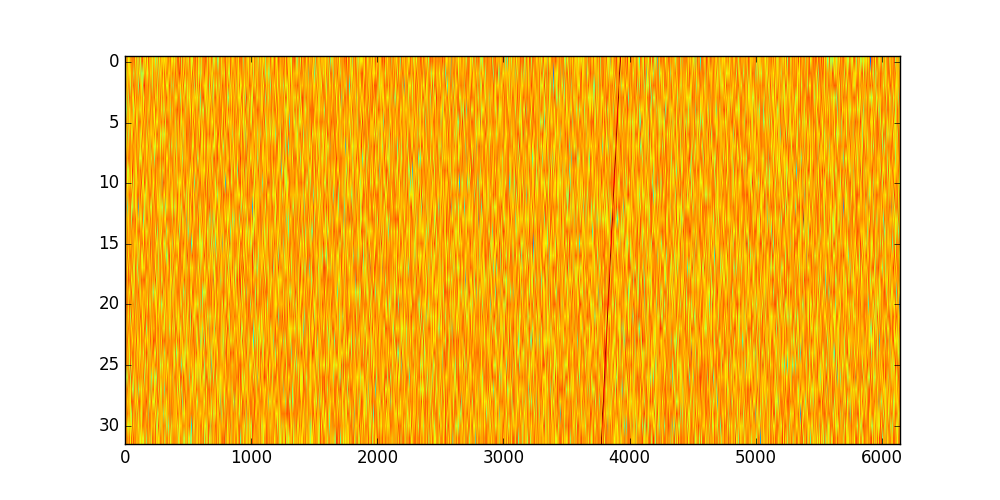

In [22]:
from IPython.display import Image
squigImg = randomSignal.read()
Image(squigImg)

In [23]:
#note - have to 'open' this again because it was already .read() out in the line above
randomSignal = zz.open(test_list[10],'r')

url_result = vr.classify(images_file=randomSignal, classifier_ids=classifier_id, threshold=0.0)

print(json.dumps(url_result, indent=2))

{
  "images": [
    {
      "image": "gpfs/fs01/user/s18f-42b3305d048694-5fca760d00b1/notebook/work/machine_contact_png/png/86a3cde6-be85-4130-a2a7-d374c2fd16ff.dat.png", 
      "classifiers": [
        {
          "classes": [
            {
              "score": 0.428924, 
              "class": "narrowband"
            }, 
            {
              "score": 0.599249, 
              "class": "narrowbanddrd"
            }, 
            {
              "score": 0.168597, 
              "class": "noise"
            }, 
            {
              "score": 0.0646768, 
              "class": "squiggle"
            }
          ], 
          "classifier_id": "machine_contact_png_v1__1483032599", 
          "name": "machine_contact_png_v1_"
        }
      ]
    }
  ], 
  "custom_classes": 4, 
  "images_processed": 1
}


<br/>
## Run the Complete Test Set



In [24]:
#Create a dictionary object to store results from Watson

from collections import defaultdict

class_list = ['squiggle', 'noise', 'narrowband', 'narrowbanddrd']

results_group_by_class = {}
for classification in class_list:
    results_group_by_class[classification] = defaultdict(list)
    
failed_to_classify_uuid_list = []

print classifier_id

results_group_by_class


machine_contact_png_v1__1483032599


{'narrowband': defaultdict(list, {}),
 'narrowbanddrd': defaultdict(list, {}),
 'noise': defaultdict(list, {}),
 'squiggle': defaultdict(list, {})}

In [25]:
# locate test archives that were produced in step 3 and add them to the test set
test_set = []
for classification in class_list:
    test_set = np.concatenate((test_set, sorted(glob.glob('{}/testset_*_{}.zip'.format(zipfilefolder, classification)))))

In [26]:
test_set

array([ '/gpfs/fs01/user/s18f-42b3305d048694-5fca760d00b1/notebook/work/machine_contact_png/zipfiles/testset_1_squiggle.zip',
       '/gpfs/fs01/user/s18f-42b3305d048694-5fca760d00b1/notebook/work/machine_contact_png/zipfiles/testset_2_squiggle.zip',
       '/gpfs/fs01/user/s18f-42b3305d048694-5fca760d00b1/notebook/work/machine_contact_png/zipfiles/testset_3_squiggle.zip',
       '/gpfs/fs01/user/s18f-42b3305d048694-5fca760d00b1/notebook/work/machine_contact_png/zipfiles/testset_4_squiggle.zip',
       '/gpfs/fs01/user/s18f-42b3305d048694-5fca760d00b1/notebook/work/machine_contact_png/zipfiles/testset_5_squiggle.zip',
       '/gpfs/fs01/user/s18f-42b3305d048694-5fca760d00b1/notebook/work/machine_contact_png/zipfiles/testset_6_squiggle.zip',
       '/gpfs/fs01/user/s18f-42b3305d048694-5fca760d00b1/notebook/work/machine_contact_png/zipfiles/testset_7_squiggle.zip',
       '/gpfs/fs01/user/s18f-42b3305d048694-5fca760d00b1/notebook/work/machine_contact_png/zipfiles/testset_8_squiggle.zip',

In [27]:
for image_archive_name in test_set:
    image_count = 0
    # count number of images in <image_archive_name>
    with zipfile.ZipFile(image_archive_name,'r') as image_archive:
        images = image_archive.namelist()
        image_count = len(images)

    # bulk classify images in <image_archive_name>
    with open(image_archive_name, 'rb') as images_file:
        print 'Running test ({} images) for {}... this may take a while.'.format(image_count, image_archive_name)
        startTimer = timeit.default_timer()
        classify_results = vr.classify(images_file=images_file, classifier_ids=[classifier_id], threshold=0.0)
        # print(json.dumps(classify_results, indent=2))
        # identify class from ZIP file name, e.g. testset_10_squiggle.zip
        mo = re.match('^(.+)_(\d+)_(.+)\.zip$',image_archive_name.split('/')[-1])
        classification = mo.group(3)
        resdict = results_group_by_class[classification]
        passed = 0
            
        for classify_result in classify_results['images']:
            pngfilename = classify_result['image'].split('/')[-1]
            uuid = pngfilename.split('.')[0]
                
            maxscore = 0
            maxscoreclass = None

            if "error" in classify_result:
                # print error information
                print classify_result
                #add to failed list
                failed_to_classify_uuid_list.append(uuid)                  
            else:
                classifiers_arr = classify_result['classifiers']
                score_list = []
                for classifier_result in classifiers_arr:
                    for class_result in classifier_result['classes']:
                        score_list.append((class_result['class'],class_result['score']))
                        if class_result['score'] > maxscore:
                            maxscore = class_result['score']
                            maxscoreclass = class_result['class']
                            
                #sort alphabetically
                score_list.sort(key = lambda x: x[0])
                score_list = map(lambda x:x[1], score_list)
                        
                if maxscoreclass is None:
                    print 'Failed: {} - Actual: {}, No classification returned'.format(pngfilename, classification)
                    #print(json.dumps(classify_result, indent=2))
                elif maxscoreclass != classification:
                    print 'Failed: {} - Actual: {}, Watson Predicted: {} ({})'.format(pngfilename, classification, maxscoreclass, maxscore)
                else:
                    passed += 1
                    print 'Passed: {} - Actual: {}, Watson Predicted: {} ({})'.format(pngfilename, classification, maxscoreclass, maxscore)

                if maxscoreclass is not None:
                    resdict['signal_classification'].append(classification)
                    resdict['uuid'].append(uuid)
                    resdict['watson_class'].append(maxscoreclass)
                    resdict['watson_class_score'].append(maxscore)
                    resdict['scores'].append(score_list)
                else:
                    #add to failed list
                    failed_to_classify_uuid_list.append(uuid)                
           
        stopTimer = timeit.default_timer()
        
        print 'Test Score: {}% ({} of {} Passed)'.format(int((float(passed) / image_count) * 100), passed, image_count)
        print 'Tested {} images in {} minutes'.format(image_count, int(stopTimer - startTimer) / 60)
        
print "DONE."

Running test (77 images) for /gpfs/fs01/user/s18f-42b3305d048694-5fca760d00b1/notebook/work/machine_contact_png/zipfiles/testset_1_squiggle.zip... this may take a while.


WatsonException: Unknown error

In [ ]:
import pickle
pickle.dump(results_group_by_class, open(mydatafolder + '/' + "watson_results.pickle", "w"))

In [ ]:
watson_results = pickle.load(open(mydatafolder + '/' + "watson_results.pickle","r"))
# reorganize the watson_results dictionary to extract
# a list of [true_class, [scores], estimated_class] and
# use these for measuring our model's performance

class_scores = []
for k in watson_results.keys():
    class_scores += zip(watson_results[k]['uuid'], watson_results[k]['signal_classification'], watson_results[k]['scores'], watson_results[k]['watson_class'] )

In [ ]:
class_scores[100]

In [ ]:
from sklearn.metrics import classification_report
import sklearn

y_train = [x[1] for x in class_scores]
y_pred = [x[3] for x in class_scores]
y_prob = [x[2] for x in class_scores]
#we normalize the Watson score values to 1 in order to use them in the log_loss calculation even though the Watson VR scores are not true class prediction probabilities
y_prob = map(lambda x: (x, sum(x)), y_prob)
y_prob = map(lambda x: [y / x[1] for y in x[0]], y_prob)

print sklearn.metrics.classification_report(y_train,y_pred)
print sklearn.metrics.confusion_matrix(y_train,y_pred)
print("Classification accuracy: %0.6f" % sklearn.metrics.accuracy_score(y_train,y_pred) )
print("Log Loss: %0.6f" % sklearn.metrics.log_loss(y_train,y_prob) )

# Generate CSV file for Scoreboard

Here's an example of what the CSV file should look like for submission to the scoreboard. Although, in this case, we only have 4 classes instead of 7.

#### NOTE: This uses the PNG files created in the Step 3 notebook, which only contain the BASIC4 data set. The code challenge and hackathon will be based on the Primary Data Set which contains 7 signal classes

In [ ]:
import csv
my_output_results = mydatafolder + '/' + 'watson_scores.csv'
with open(my_output_results, 'w') as csvfile:
    fwriter = csv.writer(csvfile, delimiter=',')
    for row in class_scores:
        fwriter.writerow([row[0]] + row[2])

In [ ]:
#print out the first 10 lines just to show it makes sense

!head -n 10 $mydatafolder/watson_scores.csv

In [ ]:
credentials = {
  'auth_uri':'',
  'global_account_auth_uri':'',
  'username':'xx',
  'password':"xx",
  'auth_url':'https://identity.open.softlayer.com',
  'project':'xx',
  'project_id':'xx',
  'region':'dallas',
  'user_id':'xx',
  'domain_id':'xx',
  'domain_name':'xx',
  'tenantId':'xx'
}

import swiftclient.client as swiftclient

conn = swiftclient.Connection(
    key=credentials['password'],
    authurl=credentials['auth_url']+"/v3",
    auth_version='3',
    os_options={
        "project_id": credentials['project_id'],
        "user_id": credentials['user_id'],
        "region_name": credentials['region']})

myObjectStorageContainer = 'hackathon_scores'  
conn_seti_data.post_container(myObjectStorageContainer)  #creates a new container in your object storage

#classification_results_file = 'my_team_name_data_folder/results/my_final_testset_classes.csv'
etag = conn.put_object(myObjectStorageContainer, 'watson_scores.csv', open(my_output_results).read())
